In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
from pathlib import Path
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVR, LinearSVR
from sklearn.kernel_ridge import KernelRidge
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LassoCV, LinearRegression, RidgeCV
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.model_selection import train_test_split, cross_val_score
from xgboost import XGBRegressor

In [2]:
import warnings
from warnings import simplefilter
from sklearn.exceptions import ConvergenceWarning
simplefilter("ignore", category=ConvergenceWarning)
from warnings import filterwarnings
filterwarnings('ignore')

# Disable convergence warnings
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [3]:
# # INPUT Features

train_df = pd.read_pickle('../../02-FeatureSets/all_features.pkl')
unknown_df = pd.read_pickle('../../07-UnlabeledSets/all_features.pkl')

In [4]:
# CAREFULLY SELECTED LIST OF DESCRIPTORS
cols_to_keep = [
    'Mismatch', 'avg_Etotal', 'avg_hform', 'avg_evac', 'avg_efermi', 'avg_gap', 'avg_vbm', 'avg_cbm', 'avg_gap_dir', 
    'avg_gap_dir_nosoc', 'avg_gap_nosoc', 'avg_workfunction', 'avg_vbm_hse', 'avg_cbm_hse', 'avg_gap_dir_hse', 
    'avg_gap_hse', 'avg_c_11', 'avg_c_12', 'avg_E_B', 'avg_emass_vb_dir1', 'avg_emass_vb_dir2', 
    'avg_emass_cb_dir1', 'avg_emass_cb_dir2', 'avg_alphax', 'avg_alphaz', 'avg_cell_area', 'avg_cbm_hybridization', 
    'avg_cbm_score', 'avg_vbm_hybridization', 'avg_vbm_score', 'avg_cbm_s', 'avg_cbm_p', 'avg_cbm_d', 
    'avg_cbm_sp', 'avg_cbm_sd', 'avg_cbm_pd', 'avg_vbm_s', 'avg_vbm_p', 'avg_vbm_d', 'avg_vbm_sp', 'avg_vbm_sd', 
    'avg_vbm_pd', 'avg_lattice_param', 'avg_PymatgenData minimum X', 'avg_PymatgenData maximum X', 
    'avg_PymatgenData range X', 'avg_PymatgenData mean X', 'avg_PymatgenData std_dev X', 
    'avg_PymatgenData minimum atomic_mass', 'avg_PymatgenData maximum atomic_mass', 'avg_PymatgenData range atomic_mass',
    'avg_PymatgenData mean atomic_mass', 'avg_PymatgenData std_dev atomic_mass', 'avg_PymatgenData minimum atomic_radius',
    'avg_PymatgenData maximum atomic_radius', 'avg_PymatgenData range atomic_radius', 'avg_PymatgenData mean atomic_radius',
    'avg_PymatgenData std_dev atomic_radius', 'avg_PymatgenData minimum thermal_conductivity', 
    'avg_PymatgenData maximum thermal_conductivity', 'avg_PymatgenData range thermal_conductivity', 
    'avg_PymatgenData mean thermal_conductivity', 'avg_PymatgenData std_dev thermal_conductivity', 
    'avg_PymatgenData minimum melting_point', 'avg_PymatgenData maximum melting_point', 'avg_PymatgenData range melting_point', 'avg_PymatgenData mean melting_point', 'avg_PymatgenData std_dev melting_point', 'avg_cbm_spd_card', 'avg_vbm_spd_card', 'avg_vbmsite_vdw_radius', 'avg_cbmsite_vdw_radius', 'avg_cbm_mend_no', 'avg_cbmsite_mass',
    'avg_cbmsite_en', 'avg_cbmsite_nvalence', 'avg_cbmsite_mp', 'avg_cbmsite_atomic_vol', 'avg_cbmsite_atomic_radius',
    'avg_vbm_mend_no', 'avg_vbmsite_mass', 'avg_vbmsite_en', 'avg_vbmsite_nvalence', 'avg_vbmsite_mp', 
    'avg_vbmsite_atomic_vol', 'avg_vbmsite_atomic_radius', 'avg_vbm_character_d', 'avg_vbm_character_p', 
    'avg_vbm_character_s', 'avg_cbm_character_d', 'avg_cbm_character_p', 'avg_cbm_character_s', 'min_cbm', 'max_cbm',
    'min_vbm', 'max_vbm', 'anderson_gap', 'wf_diff', 'band_alignment_1', 'band_alignment_2', 'band_alignment_3'
]

# Subset the dataframe
train_df = train_df[cols_to_keep]
unknown_df = unknown_df[cols_to_keep]

# print(train_df.head())

In [5]:
target_df = pd.read_pickle('../../05-TargetProperties/target_properties.pkl')
target_df.columns

Index(['Eb', 'do', 'Eg', 'IE', 'EA', 'wf', 'CBM', 'VBM', 'Eg_type'], dtype='object')

In [6]:
target = target_df['EA']

<Axes: ylabel='EA'>

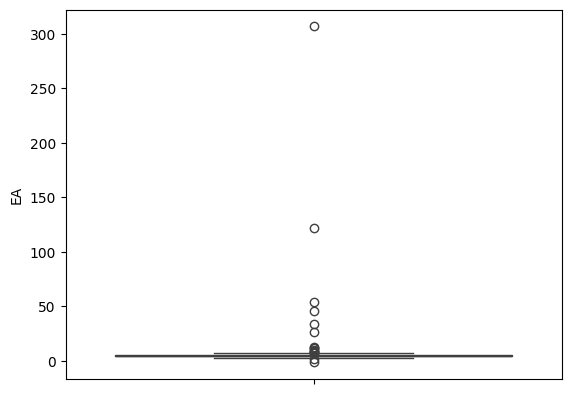

In [7]:
sns.boxplot(data=target)

In [8]:
outlier_indices = target_df[target_df['EA'] > 7].index
target_df = target_df.drop(index=outlier_indices)
train_df = train_df.drop(index=outlier_indices)

In [9]:
outlier_indices = target_df[target_df['EA'] < 3].index
target_df = target_df.drop(index=outlier_indices)
train_df = train_df.drop(index=outlier_indices)

<Axes: ylabel='EA'>

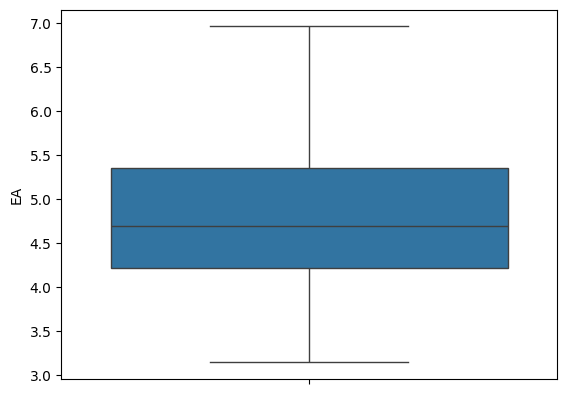

In [10]:
target = target_df['EA']
sns.boxplot(data=target)

In [11]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df, target, test_size=0.20, random_state=1
)

# y_train, y_test, X_train, X_test

In [12]:
# stacked regressor
# basemodels = [
#     ('xgb',    XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, subsample=0.8)),
#     ('gbt',    GradientBoostingRegressor()),
#     ('ridge', RidgeCV())
#     ]

basemodels = [
    ('xgb',    XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, subsample=0.8)),
    ('gbt',    GradientBoostingRegressor()),
    ('svr',    SVR(kernel='rbf'))
    ]

sem = StackingRegressor(
            estimators=basemodels, 
            final_estimator=LinearRegression())

xgb = XGBRegressor(n_estimators=1000, learning_rate=0.01, max_depth=6, subsample=0.8)

models = {
    'lasso': LassoCV(),
    'ridge': RidgeCV(),
    'svr_rbf': SVR(kernel='rbf'),
    'svr_linear': LinearSVR(),
    'adaboost': AdaBoostRegressor(),
    'rfr': RandomForestRegressor(),
    'gbt': GradientBoostingRegressor(),
    'krr_poly': KernelRidge(kernel='poly'),
    'xgb': xgb
}

In [13]:
l1 = LassoCV(alphas=np.linspace(0.001, 0.01, 10), max_iter=4500, cv=5)
lasso_fs = SelectFromModel(l1)

In [14]:
# Pipeline for preprocessing numerical features
num_pipe = Pipeline(steps=[
    ('scale_features', StandardScaler())
])

# Column transformer to apply transformations
preprocessing_pipe = ColumnTransformer(transformers=[
    ('num_features', num_pipe, list(train_df.columns))
])

# Pipeline with Lasso feature selection
feat_select_scale_pipe = Pipeline(steps=[
    ('preprocessing', preprocessing_pipe),
    ('feature_selection', lasso_fs),
])

# Full pipeline for individual models
individual_pipelines = {
    name: Pipeline(steps=[
        ('preprocessing', preprocessing_pipe),
        ('feature_selection', lasso_fs),
        ('model', model)
    ]) for name, model in models.items()
}

# SEM pipeline
full_pipeline = Pipeline(steps=[
    ('preprocessing', preprocessing_pipe),
    ('feature_selection', lasso_fs),
    ('model', sem)
])

In [15]:
feat_select_scale_pipe.fit(X_train, y_train)
print("Number of features before selection:", X_train.shape[1])
print("Number of features after selection:", feat_select_scale_pipe['feature_selection'].transform(X_train).shape[1])

Number of features before selection: 101
Number of features after selection: 35


In [16]:
def get_lasso_features(pipe, train_df): 
    # Access the fitted LassoCV estimator within SelectFromModel
    estimator = pipe['feature_selection'].estimator_
    coefs = estimator.coef_
    # Create DataFrame with coefficients for non-zero features
    coefs_df = pd.DataFrame(coefs, columns=['lasso_coefs'], index=train_df.columns)
    coefs_df = coefs_df[coefs_df['lasso_coefs'].abs() > 0].dropna()
    coefs_df = coefs_df.sort_values('lasso_coefs', ascending=False)
    return coefs_df

def save_lasso_features(pipe, train_df, filename='lasso_coefs.csv'): 
    coefs_df = get_lasso_features(pipe, train_df)
    coefs_df.to_csv(filename)

feat_select_scale_pipe.fit(X_train, y_train)
save_lasso_features(feat_select_scale_pipe, X_train)

In [17]:
# Feature selection
X_train_selected = feat_select_scale_pipe.fit_transform(X_train, y_train)
feat_indices = feat_select_scale_pipe.named_steps['feature_selection'].get_support(indices=True)
feat_indices_count = len(feat_indices)
selected_features = [X_train.columns[i] for i in feat_indices]
print(f"Selected features: {selected_features}")
print(f"Number of Selected features: {feat_indices_count}")

# Feature importance for Lasso
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    lasso_fs.fit(X_train_selected, y_train)
    coefficients = lasso_fs.estimator_

Selected features: ['Mismatch', 'avg_gap_dir_nosoc', 'avg_gap_nosoc', 'avg_workfunction', 'avg_c_12', 'avg_E_B', 'avg_emass_vb_dir1', 'avg_emass_cb_dir1', 'avg_alphax', 'avg_alphaz', 'avg_cbm_score', 'avg_cbm_s', 'avg_cbm_pd', 'avg_vbm_sd', 'avg_vbm_pd', 'avg_lattice_param', 'avg_PymatgenData maximum X', 'avg_PymatgenData range X', 'avg_PymatgenData minimum atomic_mass', 'avg_PymatgenData mean atomic_mass', 'avg_PymatgenData mean atomic_radius', 'avg_PymatgenData std_dev atomic_radius', 'avg_PymatgenData minimum thermal_conductivity', 'avg_PymatgenData maximum thermal_conductivity', 'avg_PymatgenData minimum melting_point', 'avg_cbm_spd_card', 'avg_cbmsite_vdw_radius', 'avg_cbmsite_atomic_vol', 'avg_cbm_character_p', 'min_cbm', 'min_vbm', 'max_vbm', 'wf_diff', 'band_alignment_1', 'band_alignment_3']
Number of Selected features: 35


In [18]:
plt.rcParams.update({
    'font.family': 'serif',
    'font.serif': 'Times New Roman',
    'font.size': 14,
    'axes.labelsize': 14,
    'axes.titlesize': 14,
    'legend.fontsize': 12,
    'xtick.labelsize': 12,
    'ytick.labelsize': 12,
})

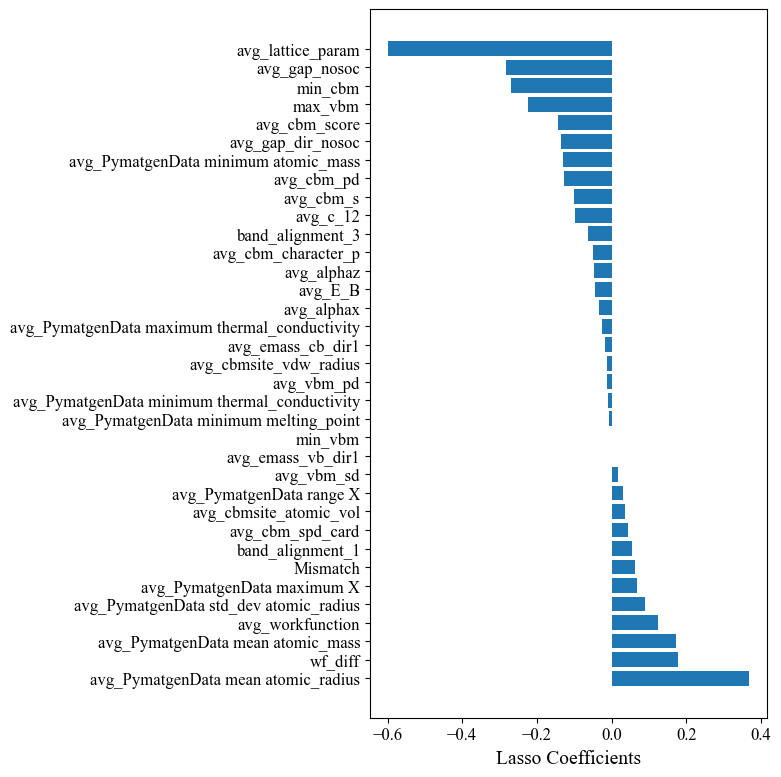

In [19]:
# Fit the Lasso model again to get the coefficients
lasso_fs.fit(X_train_selected, y_train)

# Access the underlying Lasso model and its coefficients
coefficients = lasso_fs.estimator_.coef_

# Plotting the selected descriptors vs. their Lasso coefficients
sorted_indices = np.argsort(coefficients)[::-1]
sorted_features = [selected_features[i] for i in sorted_indices]
sorted_coefficients = coefficients[sorted_indices]

plt.figure(figsize=(8, 8))
plt.barh(sorted_features, sorted_coefficients)
plt.xlabel('Lasso Coefficients')
plt.tight_layout()
# plt.savefig(f'coefficients.tif', format='tif', dpi=720)


In [20]:
# Correlation matrix for Lasso selected descriptors
lasso_selected_descriptors = X_train[selected_features]
corr_matrix = lasso_selected_descriptors.corr()
corr_matrix_reversed = corr_matrix.iloc[::-1]
# Create a mask for the upper triangle
mask = np.triu(np.ones_like(corr_matrix_reversed, dtype=bool))
corr_matrix_reversed.to_csv('cmap.csv')

# Plot the heatmap
# plt.figure(figsize=(15, 13))
# sns.heatmap(corr_matrix, mask=mask, annot=False, cmap='coolwarm', fmt=".3f", vmin=-1, vmax=1, cbar_kws={"shrink": .8}, linewidths=0.5, linecolor='white')
# plt.tight_layout()

In [21]:
from sklearn.metrics import mean_absolute_error

metrics_file_path = Path('../../04-Evaluation/EA_metrics.csv')

class TrueVPredCV(): 
    def __init__(self): 
        self.train_size = 0.8

    def fit_plot(self, pipe, X_train, X_test, y_train, y_test, model_name, ax_labels=None, save_as=None): 
        pipe.fit(X_train, y_train)
        yhat_train = pipe.predict(X_train)
        yhat_test = pipe.predict(X_test)

        r2_train = pipe.score(X_train, y_train)
        r2_test = pipe.score(X_test, y_test)
        mae_train = mean_absolute_error(y_train, yhat_train)
        mae_test = mean_absolute_error(y_test, yhat_test)

        # Five-fold Cross-Validation
        print('\nFive-fold Cross-validated training metrics')
        CV_r2_train = cross_val_score(pipe, X_train, y_train, cv=5, scoring='r2')
        CV_mae_train = cross_val_score(pipe, X_train, y_train, cv=5, scoring='neg_mean_absolute_error')
        mean_cv_r2 = CV_r2_train.mean()
        mean_cv_mae = -CV_mae_train.mean()
        std_cv_mae = CV_mae_train.std()

        print(f'\tTraining score CV: {mean_cv_r2:.2f}')
        print(f'\tTraining MAE CV: {mean_cv_mae:.2f} ± {std_cv_mae:.2f} eV')

        print('\nTraining Metrics')
        print(f'\t-Train R2: {r2_train:.2f}')
        print(f'\t-Train MAE: {mae_train:.2f} eV')

        print('\nTesting Metrics')
        print(f'\t-Test R2: {r2_test:.2f}')
        print(f'\t-Test MAE: {mae_test:.2f} eV')

        metrics_data = {
            'Model Name': [model_name],
            'Train R2': [f'{r2_train:.2f}'],
            'Train MAE': [f'{mae_train:.2f}'],
            'Test R2': [f'{r2_test:.2f}'],
            'Test MAE': [f'{mae_test:.2f}'],
            'Mean CV R2': [f'{mean_cv_r2:.2f}'],
            'Mean CV MAE': [f'{mean_cv_mae:.2f}'],
            'Std CV MAE': [f'{std_cv_mae:.2f}']
        }
        metrics_df = pd.DataFrame(metrics_data)

        # Storing metrics in CSV
        with open(metrics_file_path, 'a') as f:
            metrics_df.to_csv(f, header=f.tell()==0, index=False)

        fig, ax = plt.subplots()
        ax.scatter(y_train, yhat_train, edgecolor='k', alpha=0.8, label=f'Training: {pipe.score(X_train, y_train):.2f}')
        ax.scatter(y_test, yhat_test, edgecolor='k', alpha=0.8, label=f'Testing: {pipe.score(X_test, y_test):.2f}')
        ax.plot([min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())],
                [min(y_train.min(), y_test.min()), max(y_train.max(), y_test.max())], color='k', ls=':', zorder=-1)
        
        if ax_labels:
            ax.set_xlabel(ax_labels[0])
            ax.set_ylabel(ax_labels[1])
        else:
            ax.set_xlabel(r'$Y$')
            ax.set_ylabel(r'$\hat{Y}$')
        
        ax.legend(loc=2)
        ax.grid(True, alpha=0.1)

        if save_as:
            fig.tight_layout()
            fig.savefig(save_as, dpi=1080, format='tiff')
        else:
            plt.close(fig)
            return None


Five-fold Cross-validated training metrics
	Training score CV: 0.71
	Training MAE CV: 0.31 ± 0.03 eV

Training Metrics
	-Train R2: 1.00
	-Train MAE: 0.01 eV

Testing Metrics
	-Test R2: 0.73
	-Test MAE: 0.32 eV


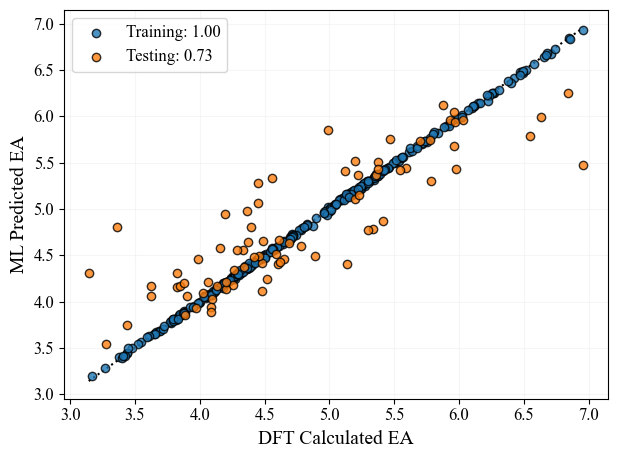

In [22]:
true_v_pred = TrueVPredCV()

true_v_pred.fit_plot(individual_pipelines['xgb'], X_train, X_test, y_train, y_test, model_name='XGBoost',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'], save_as='xgb.tif')

In [23]:
true_v_pred.fit_plot(individual_pipelines['lasso'], X_train, X_test, y_train, y_test, model_name='LASSO',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'])


Five-fold Cross-validated training metrics
	Training score CV: 0.34
	Training MAE CV: 0.36 ± 0.07 eV

Training Metrics
	-Train R2: 0.81
	-Train MAE: 0.27 eV

Testing Metrics
	-Test R2: 0.69
	-Test MAE: 0.35 eV



Five-fold Cross-validated training metrics
	Training score CV: 0.22
	Training MAE CV: 0.37 ± 0.07 eV

Training Metrics
	-Train R2: 0.80
	-Train MAE: 0.27 eV

Testing Metrics
	-Test R2: 0.69
	-Test MAE: 0.35 eV


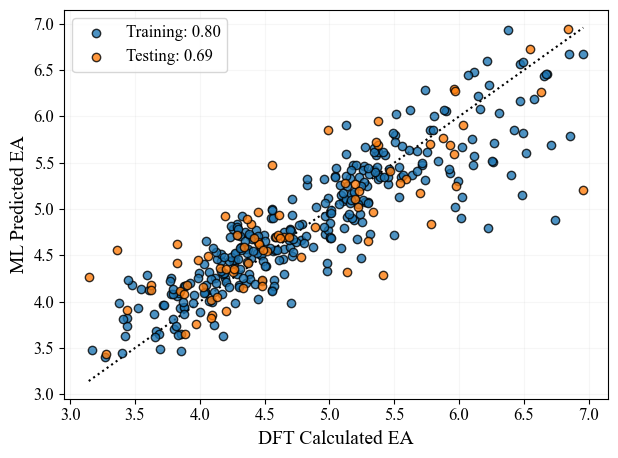

In [24]:
true_v_pred.fit_plot(individual_pipelines['ridge'], X_train, X_test, y_train, y_test, model_name='Ridge',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'], save_as='ridge.tif')


Five-fold Cross-validated training metrics
	Training score CV: 0.72
	Training MAE CV: 0.31 ± 0.03 eV

Training Metrics
	-Train R2: 0.91
	-Train MAE: 0.16 eV

Testing Metrics
	-Test R2: 0.76
	-Test MAE: 0.29 eV


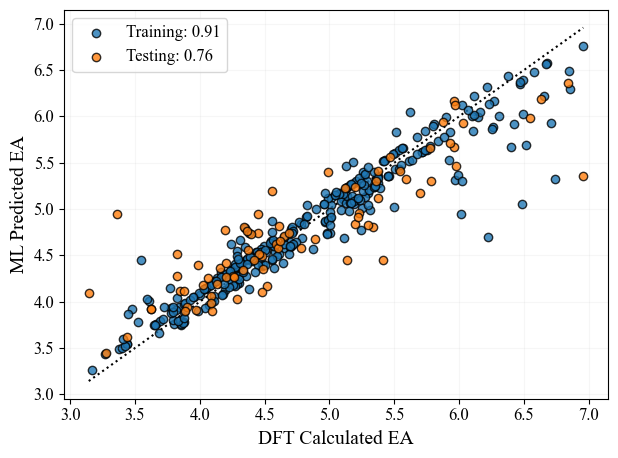

In [37]:
true_v_pred.fit_plot(individual_pipelines['svr_rbf'], X_train, X_test, y_train, y_test, model_name='SVR (kernel=rbf)',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'], save_as='svr_rbf.tif')

In [26]:
true_v_pred.fit_plot(individual_pipelines['svr_linear'], X_train, X_test, y_train, y_test, model_name='SVR (kernel=linear)',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'])


Five-fold Cross-validated training metrics
	Training score CV: 0.43
	Training MAE CV: 0.36 ± 0.05 eV

Training Metrics
	-Train R2: 0.78
	-Train MAE: 0.25 eV

Testing Metrics
	-Test R2: 0.71
	-Test MAE: 0.34 eV


In [27]:
true_v_pred.fit_plot(individual_pipelines['adaboost'], X_train, X_test, y_train, y_test, model_name='AdaBoost',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'])


Five-fold Cross-validated training metrics
	Training score CV: 0.63
	Training MAE CV: 0.38 ± 0.03 eV

Training Metrics
	-Train R2: 0.83
	-Train MAE: 0.29 eV

Testing Metrics
	-Test R2: 0.56
	-Test MAE: 0.43 eV


In [28]:
true_v_pred.fit_plot(individual_pipelines['krr_poly'], X_train, X_test, y_train, y_test, model_name='KRR (kernel=polynomial)',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'])


Five-fold Cross-validated training metrics
	Training score CV: -8670.74
	Training MAE CV: 4.57 ± 8.48 eV

Training Metrics
	-Train R2: 0.94
	-Train MAE: 0.14 eV

Testing Metrics
	-Test R2: 0.73
	-Test MAE: 0.32 eV


In [29]:
true_v_pred.fit_plot(individual_pipelines['rfr'], X_train, X_test, y_train, y_test, model_name='RFR',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'])


Five-fold Cross-validated training metrics
	Training score CV: 0.66
	Training MAE CV: 0.34 ± 0.04 eV

Training Metrics
	-Train R2: 0.96
	-Train MAE: 0.12 eV

Testing Metrics
	-Test R2: 0.64
	-Test MAE: 0.37 eV



Five-fold Cross-validated training metrics
	Training score CV: 0.69
	Training MAE CV: 0.32 ± 0.03 eV

Training Metrics
	-Train R2: 0.97
	-Train MAE: 0.11 eV

Testing Metrics
	-Test R2: 0.66
	-Test MAE: 0.37 eV


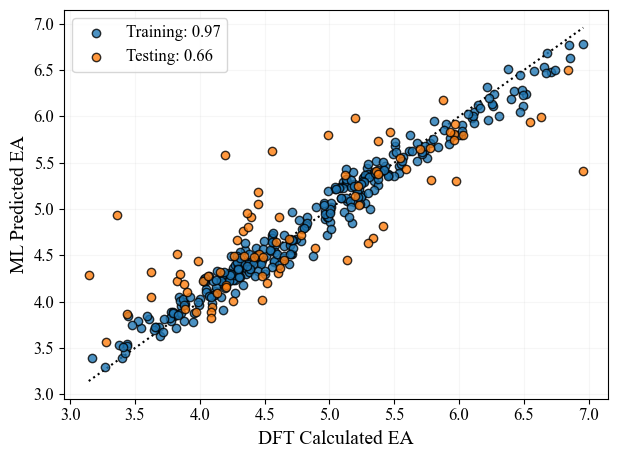

In [30]:
true_v_pred.fit_plot(individual_pipelines['gbt'], X_train, X_test, y_train, y_test, model_name='GBT',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'], save_as='gbt.tif')


Five-fold Cross-validated training metrics
	Training score CV: 0.74
	Training MAE CV: 0.29 ± 0.03 eV

Training Metrics
	-Train R2: 0.94
	-Train MAE: 0.13 eV

Testing Metrics
	-Test R2: 0.77
	-Test MAE: 0.29 eV


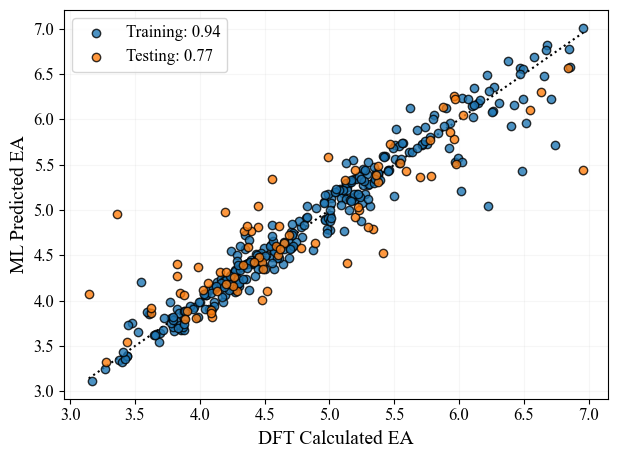

In [31]:
true_v_pred.fit_plot(full_pipeline, X_train, X_test, y_train, y_test, model_name='SEM',
                    ax_labels=['DFT Calculated EA', 'ML Predicted EA'], save_as='sem.tif')

In [32]:
import joblib

def save_pipe(pipeline, filename):
    save_path = Path('../../06-TrainedModels').joinpath(filename)
    joblib.dump(pipeline, save_path)

def train_pipeline(): 
    X,y = X_train, y_train

    print('\nRunning Training Pipeline:')
    full_pipeline.fit(X,y)
    lasso_features = save_lasso_features(full_pipeline, X)
    print('\t-training successful, saving model\n')
    save_pipe(full_pipeline, 'EA.joblib')


if __name__ == '__main__':
    train_pipeline() 


Running Training Pipeline:
	-training successful, saving model



In [33]:
from sklearn.metrics import mean_absolute_error, r2_score
def prediction_score(ytrue, ypred): 
    mae = mean_absolute_error(ytrue, ypred)
    r2 = r2_score(ytrue, ypred)
    print(f'\t-test MAE: {mae:.3f} eV')
    print(f'\t-test R2: {r2:.3f}')

def load_pipe(): 
    path = Path(f'../../06-TrainedModels/EA.joblib')
    pipe = joblib.load(path)
    return pipe

In [34]:
def predict(): 
    X,y,x_unlabeled = X_test, y_test, unknown_df 

    # load trained pipeline
    pipeline = load_pipe() 
    
    # predict on labeled data
    print(f'\nPredicting target:')
    y_pred = pipeline.predict(X)
    y_true = y.tolist() 
    pred_1 = pd.DataFrame(
        np.column_stack((y_pred, y_true)),
        columns=['y_pred', 'y_true'], 
        index = y.index
    )  
    # get training score
    prediction_score(y_true, y_pred) 

    # predict on unlabeled data
    y_pred = pipeline.predict(x_unlabeled)
    y_unlabeled = pd.DataFrame(y_pred, columns=['Unlabeled_EA'])
    y_unlabeled.to_csv('../../05-TargetProperties/Unlabeled_EA.csv')
    y_true = [np.nan] * len(x_unlabeled)
    pred_2 = pd.DataFrame(
        np.column_stack((y_pred, y_true)),
        columns=['y_pred', 'y_true'], 
        index = x_unlabeled.index
    )  

    print('\t-saving predictions to CSV file.\n')
    predictions = pd.concat((pred_1, pred_2))
    predictions.to_csv(f'predictions.csv')


if __name__ == '__main__':
    predict()


Predicting target:
	-test MAE: 0.289 eV
	-test R2: 0.764
	-saving predictions to CSV file.



In [35]:
def predict(): 
    X,y,x_unlabeled = X_test, y_test, unknown_df 

    # load trained pipeline
    pipeline = load_pipe() 
    
    # predict on labeled data
    print(f'\nPredicting target:')
    y_pred = pipeline.predict(X)
    y_true = y.tolist() 
    pred_1 = pd.DataFrame(
        np.column_stack((y_pred, y_true)),
        columns=['y_pred', 'y_true'], 
        index = y.index
    )  
    # get training score
    prediction_score(y_true, y_pred) 

    # predict on unlabeled data
    y_pred = pipeline.predict(x_unlabeled)
    y_unlabeled = pd.DataFrame(y_pred, columns=['Unlabeled_EA'])
    y_unlabeled.to_csv('../../05-TargetProperties/Unlabeled_EA.csv')
    y_true = [np.nan] * len(x_unlabeled)
    pred_2 = pd.DataFrame(
        np.column_stack((y_pred, y_true)),
        columns=['y_pred', 'y_true'], 
        index = x_unlabeled.index
    )  

    print('\t-saving predictions to CSV file.\n')
    predictions = pd.concat((pred_1, pred_2))
    predictions.to_csv(f'predictions.csv')


if __name__ == '__main__':
    predict()


Predicting target:
	-test MAE: 0.289 eV
	-test R2: 0.764
	-saving predictions to CSV file.



In [36]:
metrics_df = pd.read_csv(metrics_file_path)
metrics_df

,Model Name,Train R2,Train MAE,Test R2,Test MAE,Mean CV R2,Mean CV MAE,Std CV MAE
0,XGBoost,1.00,0.01,0.73,0.32,0.71,0.31,0.03
1,LASSO,0.81,0.27,0.69,0.35,0.34,0.36,0.07
2,Ridge,0.80,0.27,0.69,0.35,0.22,0.37,0.07
3,SVR (kernel=rbf),0.91,0.16,0.76,0.29,0.72,0.31,0.03
4,SVR (kernel=linear),0.78,0.25,0.71,0.34,0.43,0.36,0.05
5,AdaBoost,0.83,0.29,0.56,0.43,0.63,0.38,0.03
6,KRR (kernel=polynomial),0.94,0.14,0.73,0.32,-8670.74,4.57,8.48
7,RFR,0.96,0.12,0.64,0.37,0.66,0.34,0.04
8,GBT,0.97,0.11,0.66,0.37,0.69,0.32,0.03
9,SEM,0.94,0.13,0.77,0.29,0.74,0.29,0.03
